In [34]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.inspection import permutation_importance
import multiprocessing

import importlib
import warnings; warnings.simplefilter('ignore')

In [37]:
data_dir = os.environ['DATA_DIR']
img_dir = os.environ['IMG_DIR']
nb_dir = os.path.join(os.path.split(data_dir)[0], 'notebooks')
cpus = multiprocessing.cpu_count()
if cpus > 1:
    cpus -= 1
spec = importlib.util.spec_from_file_location("calc_enrichment_scores", os.path.join(nb_dir, "enrichment.py"))
enr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(enr)

In [3]:
strains_fp = os.path.join(data_dir, 'isolates.tsv')
bgcs_fp = os.path.join(data_dir, 'bgc_clustering_results.tsv')
bgc_pa_file = os.path.join(data_dir, 'bgc_presence_absence.tsv')
table2_fp = os.path.join(data_dir, 'table2.tsv')
supptable_bs_fp = os.path.join(data_dir, 'supplemental_table_bs_bgcs.tsv')
sa_feat_cooc_fp = os.path.join(img_dir, 'sa_features_cooccurence.png')
bs_feat_cooc_fp = os.path.join(img_dir, 'bs_features_cooccurence.png')

In [4]:
strains_df = pd.read_csv(strains_fp, sep='\t')
strains_df.head(3)

,strain_id,selection_tool,sample_type,country,state,phylum,class,order,family,genus,...,sa_confirmed_activity,sa_purity_test,sa_purity_confirmed,bs_primary_test,bs_confirmation_test,bs_confirmed_activity,bs_purity_test,bs_purity_confirmed,sa_ml_disease_ctrl,bs_ml_disease_ctrl
0,AFS000005,genome_similarity,Soil,Uganda,Amuria,Firmicutes,Bacilli,Bacillales,Bacillaceae_H,Bacillus_C,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,AFS000006,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,35.0
2,AFS000009,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,1,1,1,1.0,1.0,1.0,1.0,1.0,NaN,80.0


In [5]:
bgc_df = pd.read_csv(bgcs_fp, sep='\t')
bgc_df.tail(3)

,strain_id,bgc_id,fam_cluster_id,clan_cluster_id,product_class,top_kcb
13407,AFS037464,AFS037464_ctg14.region001,ripps2539,ripps2539,bacteriocin,None
13408,AFS037464,AFS037464_ctg15.region001,ripps3967,ripps3967,bacteriocin,None
13409,AFS037464,AFS037464_ctg16.region001,ripps2937,ripps2937,lanthipeptide;bacteriocin,None


### Generate BGC Presence/Absence Matrix

In [ ]:
strain_search_set = set(bgc_df.query('strain_id != "MIBiG"').strain_id.tolist())
bgc_pa_dict = {a:[] for a in strain_search_set}
bgc_pa_dict['fam_cluster_id'] = []

for fam_id, fam_id_df in bgc_df.groupby(['fam_cluster_id']):
    bgc_pa_dict['fam_cluster_id'].append(fam_id)
    for afs in strain_search_set:
        present = 0
        if afs in fam_id_df.strain_id.tolist():
            present = 1
        bgc_pa_dict[afs].append(present)

bgc_pa_df = pd.DataFrame(bgc_pa_dict).set_index('fam_cluster_id')
bgc_pa_df.head()

In [6]:
bgc_pa_df.to_csv(bgc_pa_file, sep='\t', index=True)
# bgc_pa_df = pd.read_csv(bgc_pa_file, sep='\t', index_col=0)

In [7]:
strains_df[~strains_df.strain_id.isin(set(bgc_pa_df.columns.tolist()))].shape

(176, 23)

### BGC enrichment scores

In [8]:
training_strains = strains_df[(strains_df.selection_tool.isin(['diversity', 'spectrum', 'genome_similarity'])) &
                              (strains_df.strain_id.isin(bgc_pa_df.columns.tolist()))
                             ]

sa_training_strains = training_strains.query('sa_primary_test == 1')
bs_training_strains = training_strains.query('bs_primary_test == 1')

sa_active_strains = training_strains.query('sa_confirmation_test == 1')
bs_active_strains = training_strains.query('bs_confirmation_test == 1')

print(sa_training_strains.shape[0], sa_active_strains.shape[0])
print(bs_training_strains.shape[0], bs_active_strains.shape[0])

1051 93
559 52


#### Sorgum Anthracnose (SA)

In [9]:
sa_enrichment_df = enr.calc_enrichment_scores(sa_training_strains.shape[0], 
                                              sa_active_strains.shape[0], 
                                              bgc_pa_df[sa_training_strains.strain_id], 
                                              bgc_pa_df[sa_active_strains.strain_id])
sa_enrichment_df.head(10)

,active_enrich,num_actives_with_bgc,num_strains_with_bgc,act_obs_exp_ratio,fdr_corrected_pval
fam_cluster_id,,,,,
nrps4051,0.000006,28,140,2.260215,0.017900
ripps2539,0.000046,22,106,2.345506,0.064233
nrps2550,0.000200,21,108,2.197431,0.184628
ripps3390,0.000269,4,5,9.040860,0.186191
ripps4045,0.000388,22,121,2.054741,0.194941
nrps4795,0.000423,6,13,5.215881,0.194941
nrps2943,0.000687,6,14,4.843318,0.245734
pksother4889,0.000861,5,10,5.650538,0.245734
nrps4050,0.000876,19,103,2.084664,0.245734


In [10]:
total_bgcs = sa_enrichment_df.shape[0]
num_sig_bgcs = np.sum(sa_enrichment_df.fdr_corrected_pval < 0.05)
num_sig_bgcs / float(total_bgcs) # 0.04% BGCs significantly enriched in active strains

0.00036140224069389231

#### Black Sigatoka (BS)

In [11]:
bs_enrichment_df = enr.calc_enrichment_scores(bs_training_strains.shape[0], 
                                              bs_active_strains.shape[0], 
                                              bgc_pa_df[bs_training_strains.strain_id], 
                                              bgc_pa_df[bs_active_strains.strain_id])

bs_enrichment_df.head()

,active_enrich,num_actives_with_bgc,num_strains_with_bgc,act_obs_exp_ratio,fdr_corrected_pval
fam_cluster_id,,,,,
others3030,0.000022,7,12,6.270833,0.008880
pksother2939,0.000022,7,12,6.270833,0.008880
ripps2941,0.000022,7,12,6.270833,0.008880
others4222,0.000022,7,12,6.270833,0.008880
others3032,0.000045,7,13,5.788462,0.014291


In [12]:
total_bgcs = bs_enrichment_df.shape[0]
num_sig_bgcs = np.sum(bs_enrichment_df.fdr_corrected_pval < 0.05)
num_sig_bgcs / float(total_bgcs) # 0.57% BGCs significantly enriched in active strains

0.0056890012642225032

### Random Forest Feature Importance

In [13]:
bgc_pa_T = bgc_pa_df.T
bgc_pa_T.index.name = 'strain_id'

#### SA

In [14]:
sa_bgc_pa_T = bgc_pa_T.loc[sa_training_strains.strain_id]
sa_bgc_pa_T['activity'] = sa_bgc_pa_T.apply(lambda row: row.name in sa_active_strains.strain_id.tolist(), axis=1)
sa_bgc_features = sa_bgc_pa_T.drop('activity', axis=1)
sa_bgc_activity = sa_bgc_pa_T[['activity']]
print(sa_bgc_features.shape, sa_bgc_activity.shape)

(1051, 2770) (1051, 1)


In [15]:
# Select model parameters
scoring = ['recall', 'precision']
for num_trees in [5, 10, 100]:
    for tree_max_depth in [8, 32, 100]:
        tmp_rf = RandomForestClassifier(n_estimators=num_trees, 
                                        max_depth=tree_max_depth,
                                        random_state=200603)
        
        scores = cross_validate(tmp_rf, 
                                sa_bgc_features, 
                                sa_bgc_activity, 
                                scoring=scoring,
                                cv=50)
        
        print(f'num_trees: {num_trees} tree_max_depth: {tree_max_depth}')
        for k in ['test_recall', 'test_precision']:
            print('\t{} {:0.2f} +/-{:0.2f}'.format(k, scores[k].mean(), scores[k].std()*2))

num_trees: 5 tree_max_depth: 8
	test_recall 0.00 +/-0.00
	test_precision 0.00 +/-0.00
num_trees: 5 tree_max_depth: 32
	test_recall 0.11 +/-0.46
	test_precision 0.13 +/-0.58
num_trees: 5 tree_max_depth: 100
	test_recall 0.08 +/-0.42
	test_precision 0.11 +/-0.57
num_trees: 10 tree_max_depth: 8
	test_recall 0.00 +/-0.00
	test_precision 0.00 +/-0.00
num_trees: 10 tree_max_depth: 32
	test_recall 0.07 +/-0.40
	test_precision 0.09 +/-0.51
num_trees: 10 tree_max_depth: 100
	test_recall 0.06 +/-0.38
	test_precision 0.09 +/-0.55
num_trees: 100 tree_max_depth: 8
	test_recall 0.00 +/-0.00
	test_precision 0.00 +/-0.00
num_trees: 100 tree_max_depth: 32
	test_recall 0.05 +/-0.36
	test_precision 0.06 +/-0.42
num_trees: 100 tree_max_depth: 100
	test_recall 0.06 +/-0.38
	test_precision 0.07 +/-0.44


In [16]:
# Keep best parameters and build a model using full dataset
sa_rf = RandomForestClassifier(n_estimators=5,
                               max_depth=32,
                               random_state=0)
sa_rf.fit(sa_bgc_features, sa_bgc_activity)

sa_r = permutation_importance(sa_rf, sa_bgc_features, sa_bgc_activity,
                              n_repeats=10,
                              n_jobs=cpus,
                              scoring='f1',
                              random_state=0)

# We limited the number of "feature" BGCs we would use to query the rest of the collection.
# Select 99th percentile of most important features
sa_bgc_importances_df = (pd.DataFrame({'fam_cluster_id':sa_bgc_features.columns, 'sa_rf_importance':sa_r.importances_mean})
                         .sort_values(by='sa_rf_importance', ascending=False)
                         .set_index('fam_cluster_id')
                        )
sa_fi99 = sa_bgc_importances_df[sa_bgc_importances_df.sa_rf_importance > sa_bgc_importances_df.sa_rf_importance.quantile(0.99)].index.tolist() + ['activity']
enriched_features = sa_enrichment_df.sort_values(by='fdr_corrected_pval').index.tolist()[:10] + ['activity']
top_features = list(set(sa_fi99 + enriched_features))
sa_bgc_pa_tf_T = sa_bgc_pa_T[top_features]

sa_bgc_tf_features = sa_bgc_pa_tf_T.drop('activity', axis=1)
sa_bgc_tf_activity = sa_bgc_pa_tf_T[['activity']]
print(sa_bgc_tf_features.shape, sa_bgc_tf_activity.shape)

(1051, 35) (1051, 1)


In [17]:
# Build new models based on fewer, most important BGC features
def train_final_model(features, activity):
    rf = RandomForestClassifier(n_estimators=5, 
                                max_depth=32,
                                random_state=0)

    rf.fit(features, activity)

    # Check recall and precision after trimming down to a few of the features of "greatest importance"
    scores = cross_validate(rf, 
                            features, 
                            activity, 
                            scoring=scoring,
                            cv=50)

    print('Reduced feature set')
    for k in ['fit_time', 'test_recall', 'test_precision']:
        print('\t{} {:0.2f} +/-{:0.2f}'.format(k, scores[k].mean(), scores[k].std()*2))

print('\nTop Features--')
sa_rf_tf = train_final_model(sa_bgc_tf_features, sa_bgc_tf_activity)


Top Features--
Reduced feature set
	fit_time 0.01 +/-0.00
	test_recall 0.10 +/-0.49
	test_precision 0.14 +/-0.69


#### BS

In [18]:
bs_bgc_pa_T = bgc_pa_T.loc[bs_training_strains.strain_id]
bs_bgc_pa_T['activity'] = bs_bgc_pa_T.apply(lambda row: row.name in bs_active_strains.strain_id.tolist(), axis=1)
bs_bgc_features = bs_bgc_pa_T.drop('activity', axis=1)
bs_bgc_activity = bs_bgc_pa_T[['activity']]
print(bs_bgc_features.shape, bs_bgc_activity.shape)

(559, 2770) (559, 1)


In [19]:
# Keep best parameters and build a model using full dataset
bs_rf = RandomForestClassifier(n_estimators=5,
                               max_depth=32,
                               random_state=8180)
bs_rf.fit(bs_bgc_features, bs_bgc_activity)

bs_r = permutation_importance(bs_rf, bs_bgc_features, bs_bgc_activity,
                              n_repeats=10,
                              n_jobs=cpus,
                              scoring='f1',
                              random_state=0)

# Because querying the rest of the collection was expensive, 
# we had to limit the number of "feature" BGCs we would use.
# Select 99th percentile of most important features
bs_bgc_importances_df = (pd.DataFrame({'fam_cluster_id':bs_bgc_features.columns, 'bs_rf_importance':bs_r.importances_mean})
                         .sort_values(by='bs_rf_importance', ascending=False)
                         .set_index('fam_cluster_id')
                        )
bs_fi99 = bs_bgc_importances_df[bs_bgc_importances_df.bs_rf_importance > bs_bgc_importances_df.bs_rf_importance.quantile(0.99)].index.tolist() + ['activity']
bs_enriched_features = bs_enrichment_df.sort_values(by='fdr_corrected_pval').index.tolist()[:10] + ['activity']
bs_top_features = list(set(bs_fi99 + bs_enriched_features))
bs_bgc_pa_tf_T = bs_bgc_pa_T[bs_top_features]

bs_bgc_tf_features = bs_bgc_pa_tf_T.drop('activity', axis=1)
bs_bgc_tf_activity = bs_bgc_pa_tf_T[['activity']]
print(bs_bgc_tf_features.shape, bs_bgc_tf_activity.shape)

(559, 27) (559, 1)


In [20]:
# Build new model based on fewer, most important BGC features
print('Top Features--')
bs_rf_tf = train_final_model(bs_bgc_tf_features, bs_bgc_tf_activity)

Top Features--
Reduced feature set
	fit_time 0.01 +/-0.00
	test_recall 0.06 +/-0.43
	test_precision 0.07 +/-0.49


### Gather enrichment and feature importance scores.

In [21]:
sa_enrichment_df_abbrev = sa_enrichment_df.reset_index()[['fam_cluster_id', 'fdr_corrected_pval']]
sa_enrichment_df_abbrev.columns = ['fam_cluster_id', 'sa_fdr_corrected_pval']
bs_enrichment_df_abbrev = bs_enrichment_df.reset_index()[['fam_cluster_id', 'fdr_corrected_pval']]
bs_enrichment_df_abbrev.columns = ['fam_cluster_id', 'bs_fdr_corrected_pval']

feature_bgc_df = (sa_enrichment_df_abbrev
                  .merge(bs_enrichment_df_abbrev, on='fam_cluster_id', how='outer')
                  .merge(sa_bgc_importances_df, on='fam_cluster_id', how='outer')
                  .merge(bs_bgc_importances_df, on='fam_cluster_id', how='outer')
                 )

top10_sa_enriched = feature_bgc_df.sort_values(by=['sa_fdr_corrected_pval']).head(10).fam_cluster_id.tolist()
top10_bs_enriched = feature_bgc_df.sort_values(by=['bs_fdr_corrected_pval']).head(10).fam_cluster_id.tolist()
top_features = sa_fi99 + bs_fi99 + top10_sa_enriched + top10_bs_enriched

feature_bgc_df = (feature_bgc_df[feature_bgc_df.fam_cluster_id.isin(top_features)]
                  .sort_values(by=['sa_fdr_corrected_pval', 'bs_fdr_corrected_pval', 'sa_rf_importance', 'bs_rf_importance'],
                               ascending=[1, 1, 0, 0])
                  .reset_index(drop=True)
                 )

feature_bgc_df.head(3)

,fam_cluster_id,sa_fdr_corrected_pval,bs_fdr_corrected_pval,sa_rf_importance,bs_rf_importance
0,nrps4051,0.017900,1.0,0.000000,0.0
1,ripps2539,0.064233,1.0,0.040731,0.0
2,nrps2550,0.184628,1.0,0.063280,0.0


### Summarize annotations for BGCs within fam_cluster_id 

In [22]:
def get_common_annotations(df, col):
    pcs = df.groupby(col).size().sort_values(ascending=False).reset_index()
    most_common = pcs[col][0]
    return most_common
assert '1-heptadecene' == get_common_annotations(bgc_df.query('fam_cluster_id == "nrps2582"'), 'top_kcb')

def get_average_product_class(fci):
    tmp_df = bgc_df[bgc_df.fam_cluster_id == fci]
    if tmp_df.shape[0] > 0:
        return get_common_annotations(tmp_df, 'product_class')
    else:
        return ''

def get_average_kcb(fci):
    tmp_df = bgc_df[bgc_df.fam_cluster_id == fci]
    if tmp_df.shape[0] > 0:
        return get_common_annotations(tmp_df, 'top_kcb')
    else:
        return ''

feature_bgc_df['average_product_class'] = feature_bgc_df.fam_cluster_id.apply(get_average_product_class)
feature_bgc_df['average_kcb'] = feature_bgc_df.fam_cluster_id.apply(get_average_kcb)
feature_bgc_df.head(3)

,fam_cluster_id,sa_fdr_corrected_pval,bs_fdr_corrected_pval,sa_rf_importance,bs_rf_importance,average_product_class,average_kcb
0,nrps4051,0.017900,1.0,0.000000,0.0,NRPS-like,None
1,ripps2539,0.064233,1.0,0.040731,0.0,bacteriocin,None
2,nrps2550,0.184628,1.0,0.063280,0.0,NRPS,Elsinochrome A


### Determine lowest taxonomic group that encompasses BGC distribution

In [24]:
tax_levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']
def get_umbrella_tax(fci):
    strains_with_fci = bgc_pa_T[bgc_pa_T[fci] == 1].index.tolist()
    strains_set = strains_df[strains_df.strain_id.isin(strains_with_fci)]
    for t in reversed(tax_levels):
        if strains_set[t].nunique() == 1:
            return f'{t}:{strains_set[t].unique()[0]}'
    return ''
assert 'genus:Bacillus_A' == get_umbrella_tax('nrps4051')

feature_bgc_df['taxonomic_distribution'] = feature_bgc_df.fam_cluster_id.apply(get_umbrella_tax)
feature_bgc_df.head(5)

,fam_cluster_id,sa_fdr_corrected_pval,bs_fdr_corrected_pval,sa_rf_importance,bs_rf_importance,average_product_class,average_kcb,taxonomic_distribution
0,nrps4051,0.017900,1.000000,0.000000,0.0,NRPS-like,None,genus:Bacillus_A
1,ripps2539,0.064233,1.000000,0.040731,0.0,bacteriocin,None,genus:Bacillus_A
2,nrps2550,0.184628,1.000000,0.063280,0.0,NRPS,Elsinochrome A,genus:Bacillus_A
3,ripps3390,0.186191,1.000000,0.008652,0.0,bacteriocin,None,species:Bacillus_A toyonensis
4,nrps4795,0.194941,0.027689,0.000000,0.0,NRPS,Pyoverdine,species:Pseudomonas_E protegens


### Simplify for Table 2

In [25]:
top10_sa_enriched = (feature_bgc_df
                     .sort_values(by=['sa_fdr_corrected_pval'])
                     .head(10)
                     .sa_fdr_corrected_pval
                     .values[-1]
                    )
feature_bgc_df['top10_sa_enriched'] = (feature_bgc_df
                                       .sa_fdr_corrected_pval
                                       .apply(lambda x: x <= top10_sa_enriched)
                                      )

top10_bs_enriched = (feature_bgc_df
                     .sort_values(by=['bs_fdr_corrected_pval'])
                     .head(10)
                     .bs_fdr_corrected_pval
                     .values[-1]
                    )
feature_bgc_df['top10_bs_enriched'] = (feature_bgc_df
                                       .bs_fdr_corrected_pval
                                       .apply(lambda x: x <= top10_bs_enriched)
                                      )

feature_bgc_df['top_sa_importance'] = (feature_bgc_df
                                       .fam_cluster_id
                                       .apply(lambda x: x in sa_fi99)
                                      )

feature_bgc_df['top_bs_importance'] = (feature_bgc_df
                                       .fam_cluster_id
                                       .apply(lambda x: x in bs_fi99)
                                      )

feature_bgc_df['sa_sum'] = (feature_bgc_df.top_sa_importance + feature_bgc_df.top10_sa_enriched)

(feature_bgc_df
 .query('top10_sa_enriched | top_sa_importance')
 .sort_values(by=['sa_sum', 'top_sa_importance'], ascending=[0,0])
 .reset_index(drop=True)
 [['fam_cluster_id', 'top_sa_importance', 'top10_sa_enriched', 'average_product_class', 'average_kcb', 'taxonomic_distribution']]
 .to_csv(table2_fp, sep='\t', index=False)
)

In [26]:
feature_bgc_df['bs_sum'] = (feature_bgc_df.top_bs_importance + feature_bgc_df.top10_bs_enriched)

(feature_bgc_df
 .query('top10_bs_enriched | top_bs_importance')
 .sort_values(by=['bs_sum', 'top_bs_importance'], ascending=[0,0])
 .reset_index(drop=True)
 [['fam_cluster_id', 'top_bs_importance', 'top10_bs_enriched', 'average_product_class', 'average_kcb', 'taxonomic_distribution']]
 .to_csv(supptable_bs_fp, sep='\t', index=False)
)

### Check for co-ocurrence between selected features

In [27]:
def calc_bgc_cooccurrence(training_data):
    co_mat = np.zeros([training_data.shape[1], training_data.shape[1]])
    co_mat_df = pd.DataFrame(data=co_mat, columns=training_data.columns, index=training_data.columns)
    for x, bci_x in enumerate(training_data.columns):
        for bci_y in training_data.columns[x:]:
            hits_x = set(training_data[training_data[bci_x] == 1].index.tolist())
            hits_y = set(training_data[training_data[bci_y] == 1].index.tolist())
            intersection = len(hits_x.intersection(hits_y))
            union = len(hits_x.union(hits_y))
            if union > 0:
                jaccard_i = intersection / union 
            else:
                jaccard_i = 0
            co_mat_df.loc[bci_y, bci_x] = jaccard_i
            co_mat_df.loc[bci_x, bci_y] = jaccard_i
    return co_mat_df

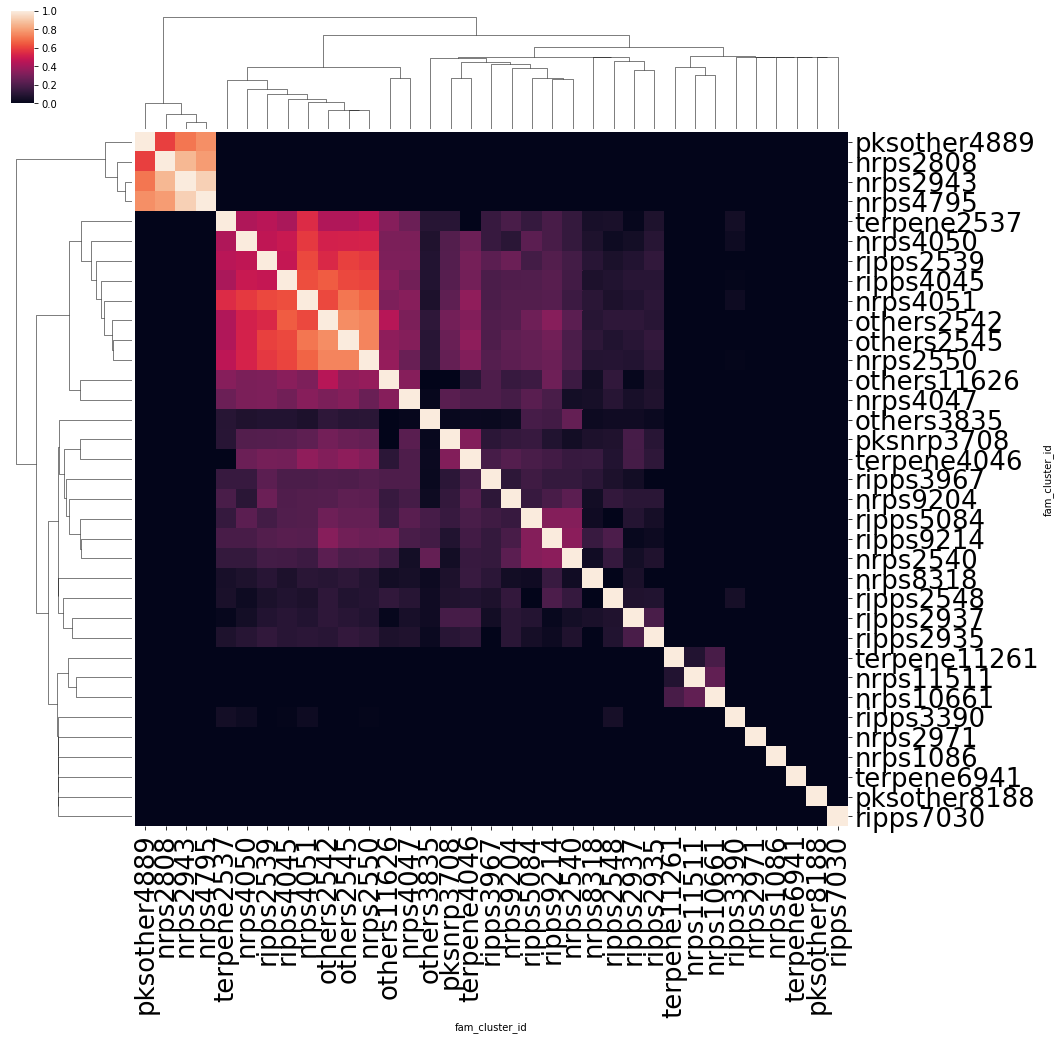

In [30]:
sa_co_mat_df = calc_bgc_cooccurrence(sa_bgc_tf_features)
g = sns.clustermap(sa_co_mat_df, figsize=(15, 15), standard_scale=None)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=26);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=26);

In [31]:
g.savefig(sa_feat_cooc_fp)

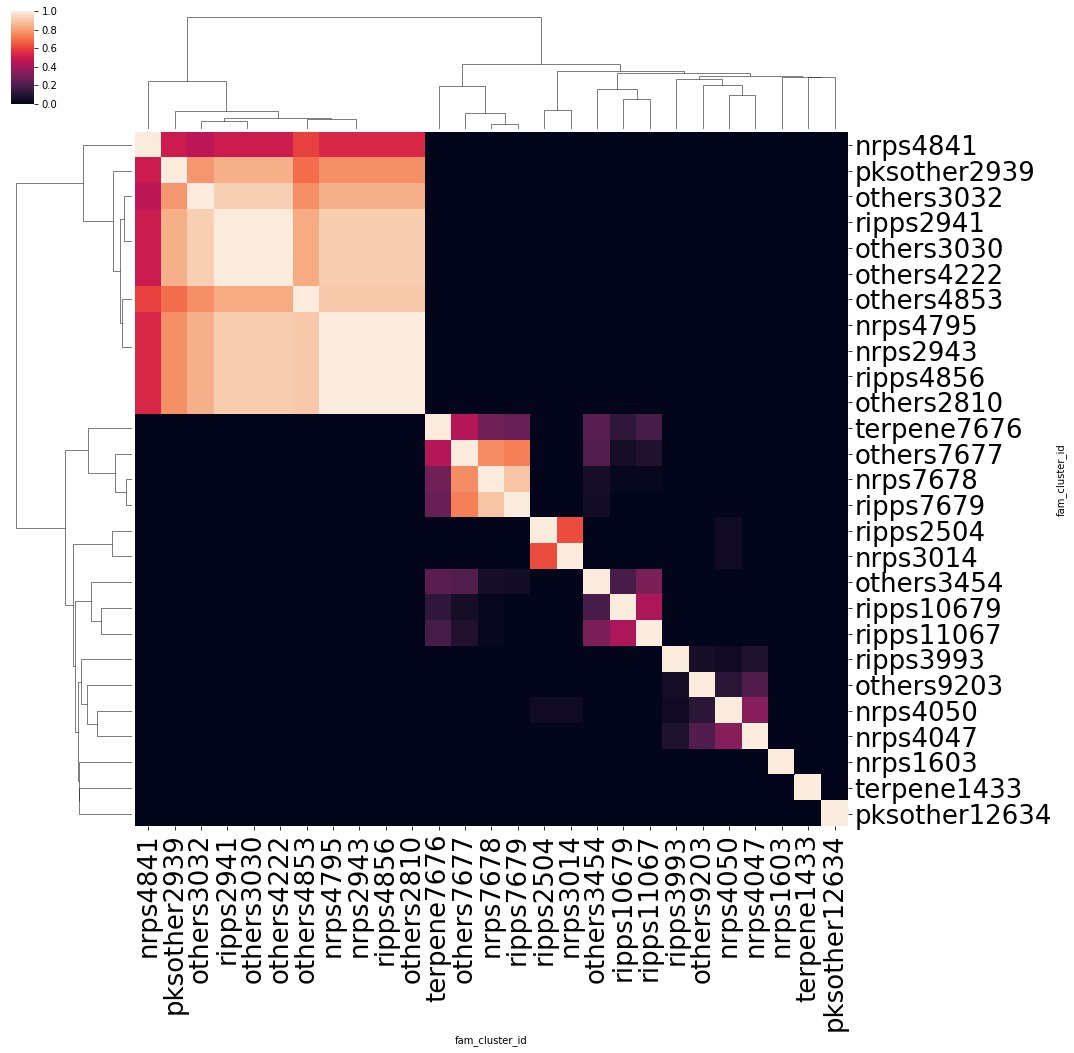

In [32]:
bs_co_mat_df = calc_bgc_cooccurrence(bs_bgc_tf_features)
g = sns.clustermap(bs_co_mat_df, figsize=(15, 15), standard_scale=None)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=26);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=26);

In [33]:
g.savefig(bs_feat_cooc_fp)